# Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from keras.applications.inception_v3 import InceptionV3
from keras.src.applications.densenet import DenseNet121


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
tf.get_logger().setLevel("ERROR")

# Data Loading & Preprocessing

In [3]:
x_train = []
y_train = []
x_test = []
y_test = []
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_sizes = [256, 256, 256, 299, 224] 

In [4]:
for i in labels:
    folderPath = os.path.join('data/brain-tumor-mri-dataset/Training', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (max(image_sizes), max(image_sizes)))
        x_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('data/brain-tumor-mri-dataset/Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (max(image_sizes), max(image_sizes)))
        x_test.append(img)
        y_test.append(i)

In [5]:
# Convert to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)   
y_test = np.array(y_test)

x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

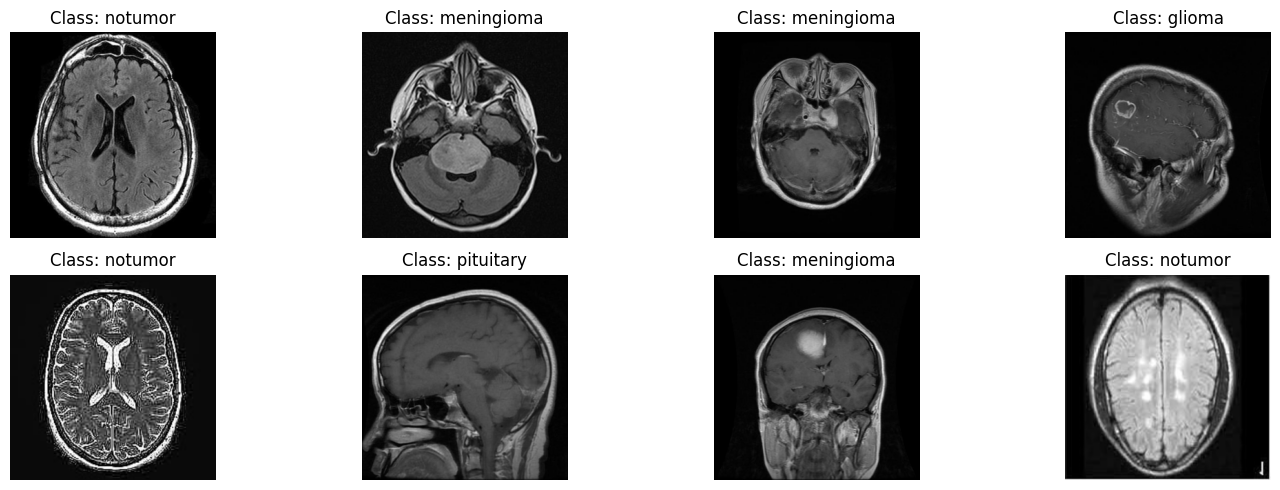

In [7]:
def plot_sample_images(data, labels, class_names, num_samples=8):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(data))
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(data[idx].astype('uint8'))
        plt.title(f'Class: {class_names[labels[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(x_train, [labels.index(lbl) for lbl in y_train], labels, num_samples=8)

In [8]:
# One-Hot Encoding
Y_ohe_train_list = [labels.index(i) for i in Y_train]
Y_ohe_val_list = [labels.index(i) for i in Y_val]
Y_ohe_test_list = [labels.index(i) for i in y_test]

Y_ohe_train = tf.keras.utils.to_categorical(Y_ohe_train_list)
Y_ohe_val = tf.keras.utils.to_categorical(Y_ohe_val_list)
Y_ohe_test = tf.keras.utils.to_categorical(Y_ohe_test_list)


# Model Architecture Setup

In [9]:
models = []
model_names = ['VGG19', 'ResNet50', 'ResNet101', 'InceptionV3', 'DenseNet121']

In [10]:
# Model 1: VGG19
base_model_vgg19 = VGG19(weights=None, include_top=False, input_shape=(image_sizes[0], image_sizes[0], 3))
x = base_model_vgg19.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4, activation='softmax')(x)
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=x)
models.append(model_vgg19)

In [11]:
# Model 2: ResNet50
base_model_resnet50 = ResNet50(weights=None, include_top=False, input_shape=(image_sizes[1], image_sizes[1], 3))
x = base_model_resnet50.output
x = Flatten()(x)
x = Dense(4, activation='softmax')(x)
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=x)
models.append(model_resnet50)

In [12]:
# Model 3: ResNet101
base_model_resnet101 = ResNet101(weights=None, include_top=False, input_shape=(image_sizes[2], image_sizes[2], 3))
x = base_model_resnet101.output
x = AveragePooling2D((8, 8))(x)
x = Flatten()(x)
x = Dense(4, activation='softmax')(x)
model_resnet101 = Model(inputs=base_model_resnet101.input, outputs=x)
models.append(model_resnet101)

In [13]:
# Model 4: InceptionV3
base_model_inceptionv3 = InceptionV3(weights=None, include_top=False, input_shape=(image_sizes[3], image_sizes[3], 3))
x = base_model_inceptionv3.output
x = AveragePooling2D((8, 8))(x)
x = Dense(2048, activation='relu')(x)
x = Flatten()(x)
x = Dense(4, activation='softmax')(x)
model_inceptionv3 = Model(inputs=base_model_inceptionv3.input, outputs=x)
models.append(model_inceptionv3)

In [14]:
# Model 5: DenseNet121
base_model_densenet121 = DenseNet121(weights=None, include_top=False, input_shape=(image_sizes[4], image_sizes[4], 3))
x = base_model_densenet121.output
x = GlobalAveragePooling2D()(x)
x = Dense(4, activation='softmax')(x)
model_densenet121 = Model(inputs=base_model_densenet121.input, outputs=x)
models.append(model_densenet121)


# Model Training Setup

In [15]:
callbacks = [
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)
]

def train_model(model, X_train, Y_train, X_val, Y_val, model_name, callbacks):
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, Y_train,
        epochs=15, batch_size=32, validation_data=(X_val, Y_val),
        callbacks=callbacks, verbose=1
    )
    return history



# Model Evaluation


----- Evaluation: VGG19 -----

Test Loss:      0.227
Test Accuracy:  0.959
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step


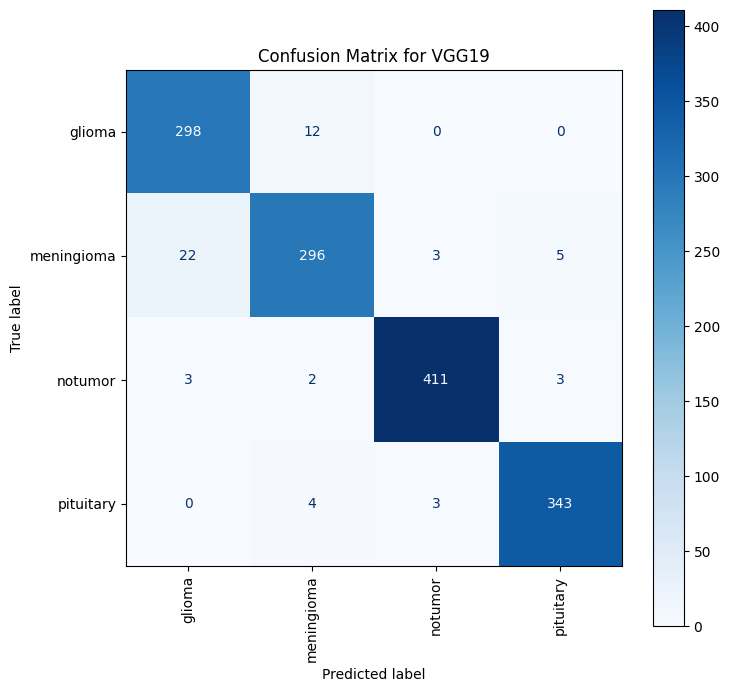


----- Evaluation: ResNet50 -----

Test Loss:      0.471
Test Accuracy:  0.834
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step


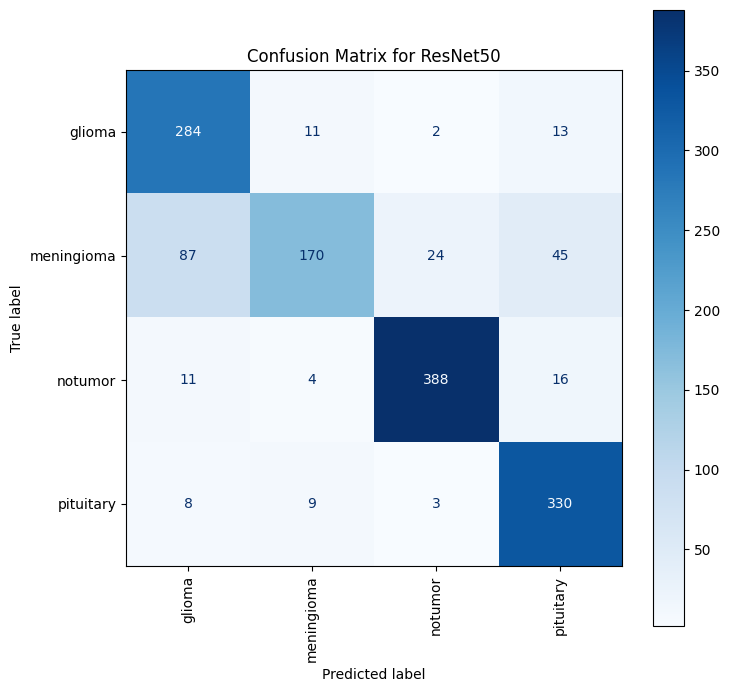


----- Evaluation: ResNet101 -----

Test Loss:      0.471
Test Accuracy:  0.831
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step


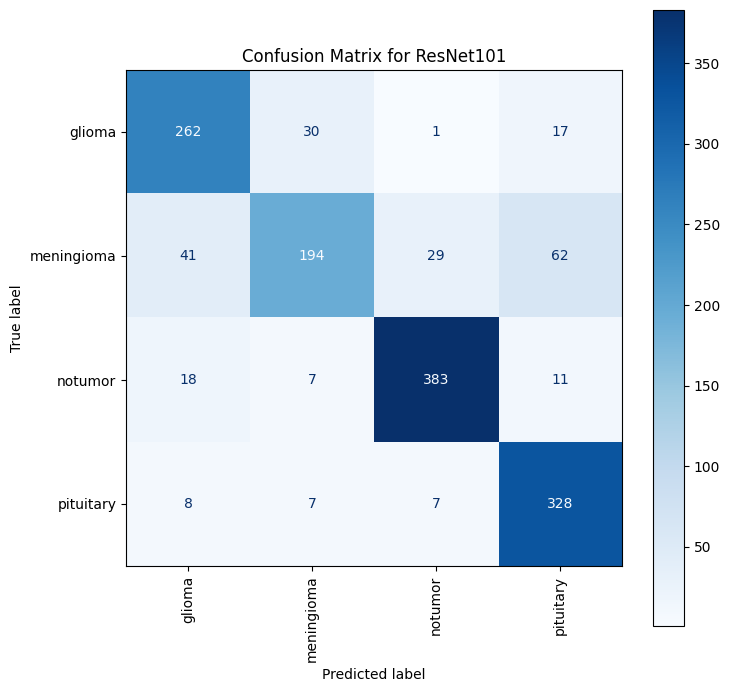


----- Evaluation: InceptionV3 -----

Test Loss:      0.200
Test Accuracy:  0.922
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step


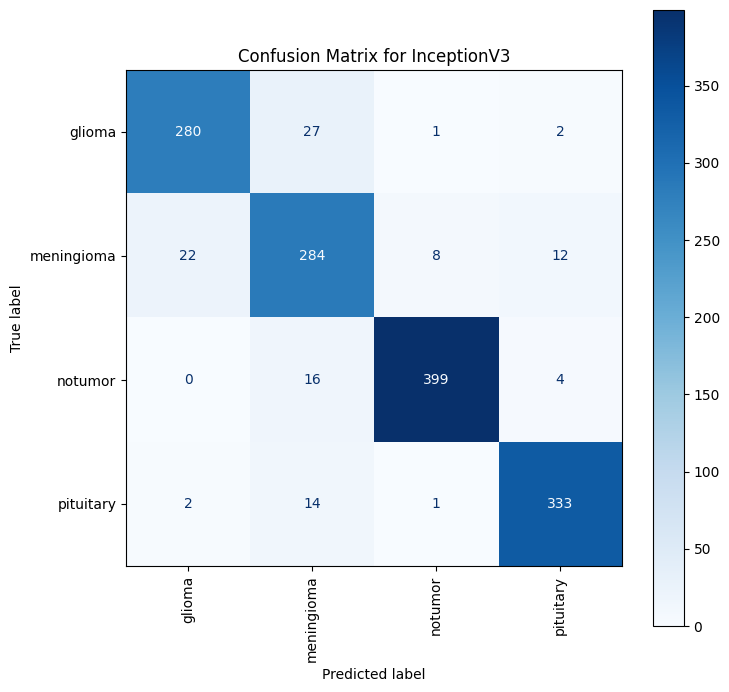


----- Evaluation: DenseNet121 -----

Test Loss:      0.220
Test Accuracy:  0.919
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step


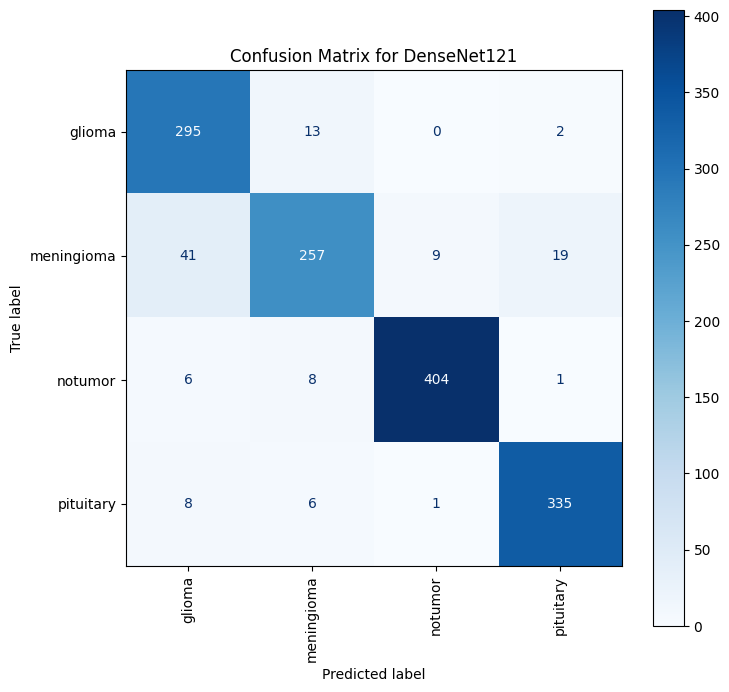

In [17]:
accuracies = []

for i, model in enumerate(models):
    print(f"\n----- Evaluation: {model_names[i]} -----\n")
    
    test_eval = model.evaluate(x_test, Y_ohe_test, verbose=0)
    print(f"Test Loss:      {test_eval[0]:.3f}")
    print(f"Test Accuracy:  {test_eval[1]:.3f}")

    predictions = model.predict(x_test)
    predict_list = predictions.argmax(axis=1)

    cm = confusion_matrix(np.argmax(Y_ohe_test, axis=1), predict_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {model_names[i]}")
    plt.show()

    accuracies.append(test_eval[1])

# Conclusion

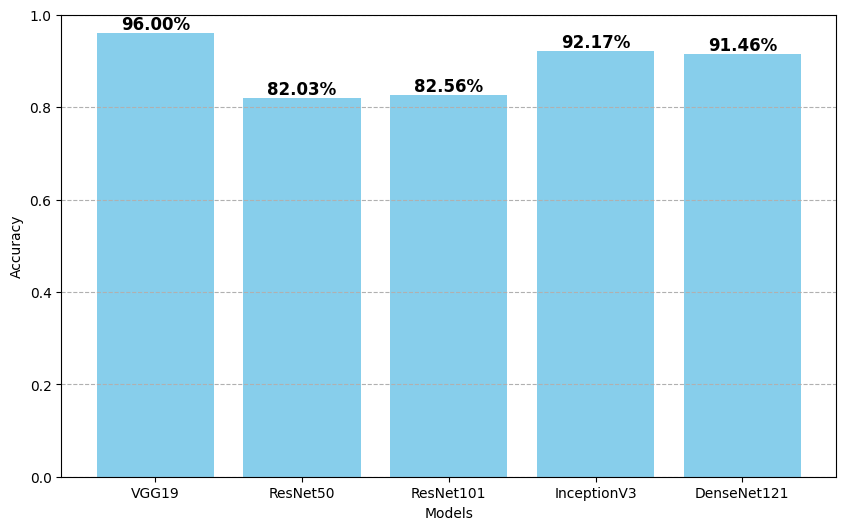

In [18]:
if accuracies:
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='skyblue')
    for index, value in enumerate(accuracies):
        plt.text(index, value, f"{value * 100:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--')
    plt.show()


VGG19 achieved the highest accuracy (~96%) among all tested architectures.
